# Import Modules

In [1]:
import os, sys, errno
import numpy as np
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from tqdm import tqdm
from glob import glob
import argparse

import json

# Params

In [2]:
ZONE_XML_PATH = '../example/zone_xmls'
OCR_XML_PATH  = '../example/ocr_xmls'
SAVE_PATH     = '../output'
IOU_THRESHOLD = 0.05
DEBUG = True

In [3]:

zone_xml_file_paths = glob(os.path.join(ZONE_XML_PATH,'**/*.xml'),recursive=True)
ocr_xml_file_paths  = glob(os.path.join(OCR_XML_PATH,'**/*.xml'),recursive=True)

idx = 1

zone_xml_file_path = zone_xml_file_paths[idx]
ocr_xml_file_path  = ocr_xml_file_paths[idx]


print("[{}/{}] Processing \nzone xml: {}\nOCR xml: {}".format(idx+1,len(zone_xml_file_paths),zone_xml_file_path,ocr_xml_file_path))


#img    = cv2.imread(img_path)

[2/2] Processing 
zone xml: ../example/zone_xmls/sn86058242-19200121_dhSegment.xml
OCR xml: ../example/ocr_xmls/sn86058242-19200121.xml


# Zone Processing

In [4]:
# Read Zone xml
xmldoc = minidom.parse(zone_xml_file_path)

# Get image dimension and resize factor
#img_w  = int(xmldoc.getElementsByTagName('Page')[0].attributes['WIDTH'].value)
#img_h  = int(xmldoc.getElementsByTagName('Page')[0].attributes['HEIGHT'].value)

img_w  = int(xmldoc.getElementsByTagName('Page')[0].attributes['WIDTH'].value)
img_h  = int(xmldoc.getElementsByTagName('Page')[0].attributes['HEIGHT'].value)

# Count number of text-blocks
zone_textBlocks = xmldoc.getElementsByTagName('TextBlock')

if DEBUG:
    print("Zone XML:")
    print("{} \tWidth (factored)".format(img_w)) 
    print("{} \tHeight (factored)".format(img_h))
    print("{} \tTextBlock(s)".format(len(zone_textBlocks)))


Zone XML:
5888 	Width (factored)
7922 	Height (factored)
20 	TextBlock(s)


# OCR Processing

In [5]:

# Read OCR xml
xmldoc = minidom.parse(ocr_xml_file_path)

# Get image dimension and resize factor
image_width  = int(xmldoc.getElementsByTagName('Page')[0].attributes['WIDTH'].value)
image_height = int(xmldoc.getElementsByTagName('Page')[0].attributes['HEIGHT'].value)

_processingStepSettings = str(xmldoc.getElementsByTagName('processingStepSettings')[0].childNodes[0].nodeValue)
_attributes = _processingStepSettings.split('\n')
        
factor = img_w/image_width

# Count number of text-blocks
ocr_textBlocks = xmldoc.getElementsByTagName('TextBlock')

if DEBUG:
    print("OCR XML:")
    print("{} \tWidth (original)".format(image_width)) 
    print("{} \tHeight (original)".format(image_height))
    print("{} \tWidth (factored)".format(img_w)) 
    print("{} \tHeight (factored)".format(img_h))
    print("{} \tTextBlock(s)".format(len(ocr_textBlocks)))


OCR XML:
23548 	Width (original)
31688 	Height (original)
5888 	Width (factored)
7922 	Height (factored)
87 	TextBlock(s)


# Mapping

In [6]:
zone_textBlocks[6]

<DOM Element: TextBlock at 0x12aa5fa60>

In [7]:
"""
MAPPING
"""
# output json
map_json = []

for zone_idx,zone_textBlock in enumerate(tqdm(zone_textBlocks)):
    # zone coordinates
    zone_width  = int(float(zone_textBlock.attributes["WIDTH"].value))
    zone_height = int(float(zone_textBlock.attributes["HEIGHT"].value))
    zone_vpos   = int(float(zone_textBlock.attributes["VPOS"].value))
    zone_hpos   = int(float(zone_textBlock.attributes["HPOS"].value))
    
    zone_p1 = (zone_hpos,zone_vpos)
    zone_p2 = ((zone_hpos+zone_width),zone_vpos)
    zone_p3 = (zone_hpos,(zone_vpos+zone_height))
    zone_p4 = ((zone_hpos+zone_width),(zone_vpos+zone_height))
    
    zone_coord = [zone_p3, zone_p4, zone_p2, zone_p1]
    
    # Build json
    _textBlock_xml = {}
    _textBlock_xml["zone_coord"] = [list(zone_p3), list(zone_p4), list(zone_p2), list(zone_p1)]
    _set_ocr_textBlocks = []
    _set_ocr_contents   = []
    
    _sub_ocr_contents   = []
    
    for ocr_idx,ocr_textBlock in enumerate(ocr_textBlocks):
        # OCR coordinates
        ocr_width  = int(float(ocr_textBlock.attributes["WIDTH"].value))
        ocr_height = int(float(ocr_textBlock.attributes["HEIGHT"].value))
        ocr_vpos   = int(float(ocr_textBlock.attributes["VPOS"].value))
        ocr_hpos   = int(float(ocr_textBlock.attributes["HPOS"].value))
    
        width  = int(ocr_width*factor)
        height = int(ocr_height*factor)
        vpos   = int(ocr_vpos*factor)
        hpos   = int(ocr_hpos*factor)
        
        ocr_p1 = (hpos,vpos)
        ocr_p2 = ((hpos+width),vpos)
        ocr_p3 = (hpos,(vpos+height))
        ocr_p4 = ((hpos+width),(vpos+height))
        
        ocr_coord = [ocr_p3, ocr_p4, ocr_p2, ocr_p1]
        
        # Find matching regions
        zone_polygon = Polygon(zone_coord)
        ocr_polygon  = Polygon(ocr_coord)
        
        iou = zone_polygon.intersection(ocr_polygon).area / zone_polygon.union(ocr_polygon).area
        
        if(iou >= IOU_THRESHOLD):
            # Set of OCR touching the Zone
            set_contents = ''
            sub_contents = ''
            ocr_textLines = ocr_textBlock.getElementsByTagName('TextLine')
            
            for ocr_textline in ocr_textLines:
                # Textline coordinates
                txt_width  = int(float(ocr_textline.attributes["WIDTH"].value))
                txt_height = int(float(ocr_textline.attributes["HEIGHT"].value))
                txt_vpos   = int(float(ocr_textline.attributes["VPOS"].value))
                txt_hpos   = int(float(ocr_textline.attributes["HPOS"].value))
                
                width  = int(txt_width*factor)
                height = int(txt_height*factor)
                vpos   = int(txt_vpos*factor)
                hpos   = int(txt_hpos*factor)

                txt_p1 = (hpos,vpos)
                txt_p2 = ((hpos+width),vpos)
                txt_p3 = (hpos,(vpos+height))
                txt_p4 = ((hpos+width),(vpos+height))

                txt_coord  = [txt_p3, txt_p4, txt_p2, txt_p1]
                
                txt_polygon = Polygon(txt_coord)
                
                # Textline string
                strings = ocr_textline.getElementsByTagName('String')
                for string in strings:
                    set_contents += (str(string.attributes["CONTENT"].value) + ' ')
                    
                    # Subset of OCR within the Zone
                    if(zone_polygon.intersects(txt_polygon)):
                        sub_contents += (str(string.attributes["CONTENT"].value) + ' ')
                
            # Build json
            _sub_ocr_contents.append(sub_contents)
            _set_ocr_textBlocks.append([list(ocr_p3), list(ocr_p4), list(ocr_p2), list(ocr_p1)])
            _set_ocr_contents.append(set_contents)

    # Build json
    _textBlock_xml["zone_texts"] = _sub_ocr_contents
    _textBlock_xml["ocr_coords"] = _set_ocr_textBlocks
    _textBlock_xml["ocr_texts"]  = _set_ocr_contents
    map_json.append(_textBlock_xml)

# Save json
data = json.dumps(map_json)
out_json_filename = os.path.basename(ocr_xml_file_path).split('.')[0] + '.json'
with open(os.path.join(SAVE_PATH,out_json_filename),'w') as out_json_fp:
    json.dump(map_json, out_json_fp) 


100%|██████████| 20/20 [00:00<00:00, 36.85it/s]


# Visualization

Load ../output/sn86058242-19200121.json
Total 20 zones are found by dhSegment.

<Inspect zone 7 out of 20>

Zone texts (4 textlines) within the OCR:
['Chief Austgen Word For "\' \'h.\'f, 1 nn a Hoy S-\'. t el I t!.e truth." \'I hot is the answer t"! Austg\'-n recentd rec-ntij i ud n i ,1.. i ief of r.\' ii- when j.t. ouitziris a twelve -year-old j:as Hi.ni- morid boy and asked. "Aro you t iiit , the trt.thV" The. Wy had l e 11 htouiiti j:u with other llKiumend boys su ij\'cte.l of s\'eaiil.R l.icycb 5 id ha. ', "Has Good The Boy Scouts I i 'i t K-tin. ' Since the Key S. out !'. lt.ts been est,'ihi;shel in a or ;aiutii-iid the poi:cc h-e had x e-ry little i..-uhb- w i: h the boy s snd never to niy i, on ledge- has a Hoy Scout caused t'-ubje reqtuMtis le-'ice a t ten t ir-n. If aoio boys vc-iild read the Key Scout oo' s lurt.-ol of at! lu'-ir.-i and i dfrsr tlieir titne s t r-i et corrse.r,- th o.i'd rect ixc ica . be-n. f.i and would ", 'TAJ FARE ', '! KILLED 111 ROW OVER ']

OCR text o

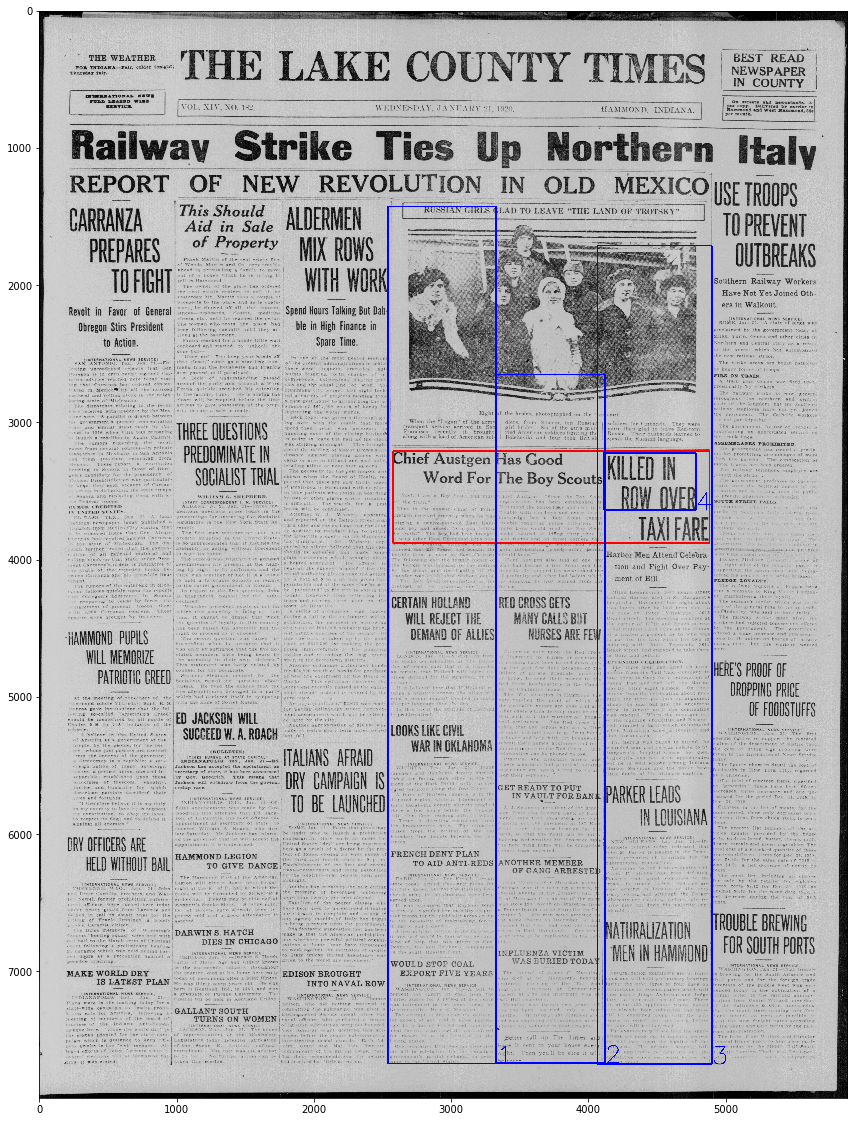

In [8]:
json_files = glob(os.path.join(SAVE_PATH,'**/*.json'),recursive=True)
json_file = json_files[0]

print("Load {}".format(json_file))

data = None
with open(json_file) as in_json_fp:
    data = json.load(in_json_fp)
print("Total {} zones are found by dhSegment.\n".format(len(data)))

# Change index number for further inspection
zone_idx = 6

print("<Inspect zone {} out of {}>\n".format(zone_idx+1,len(data)))
zone_textBox = data[zone_idx]

img = cv2.imread(os.path.join("../example/images",os.path.basename(json_file).split('.')[0] + '.jpg'))
canvas = np.copy(img)

# Draw zone region (red color)
cv2.drawContours(canvas,np.int32([np.array(zone_textBox['zone_coord'])]),0,(255,0,0),10)

print("Zone texts ({} textlines) within the OCR:\n{}\n".format(len(zone_textBox['zone_texts']), zone_textBox['zone_texts']))


for ocr_idx in range(len(zone_textBox['ocr_coords'])):
    # Draw zone region (blue color)
    cv2.drawContours(canvas,np.int32([np.array(zone_textBox['ocr_coords'][ocr_idx])]),0,(0,0,255),10)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    topLeftCornerOfText    = tuple(zone_textBox['ocr_coords'][ocr_idx][1])
    fontScale              = 6
    fontColor              = (0,0,255)
    lineType               = 6
    cv2.putText(canvas, str(ocr_idx+1), topLeftCornerOfText, font, fontScale, fontColor,lineType, cv2.LINE_AA)

    print("OCR text of region {}:\n{}\n".format(ocr_idx+1,zone_textBox['ocr_texts'][ocr_idx]))
    
plt.figure(figsize=(20,20))
plt.imshow(canvas)
plt.show()